In [1]:
import sklearn.metrics
from psycopg2.sql import SQL, Identifier, Literal, Composed

import ramda as R
from numpy import nanstd, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from itertools import product
from tqdm.notebook import tqdm
from typing import List, Union

from pathlib import Path
from joblib import Memory, memory
from psycopg2 import connect

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, roc_curve
import os
import yaml

notebook_path = os.path.abspath("Detection model (Logistic regression).ipynb")

cachedir = "./db_cache"
Path(cachedir).mkdir(exist_ok=True)
mem = Memory(location=cachedir, verbose=0)
memory._build_func_identifier = lambda func: func.__name__


def parse_yyyy_mm_dd(datestring: str) -> date:
    return datetime.strptime(datestring, "%Y-%m-%d").date()


def load_yaml_file(path) -> dict:
    with open(path, "r") as file:
        try:
            return yaml.safe_load(file)
        except yaml.YAMLError as exc:
            print(exc)


@mem.cache
def pull_from_postgres(query: Union[str, SQL, Composed]) -> pd.DataFrame:
    credentials = load_yaml_file(Path(notebook_path).with_name("postgres_credentials.yaml"))
    connection = connect(**credentials)
    res = pd.read_sql(query, connection)
    connection.close()
    return res


In [2]:
def loading_and_pre_processing_pipeline(limit, batch):
    """
    calcualte metrics from rhr and steps and join with test results and reported symptoms.

    Date in test results and symptoms data is the first day of the week for which test and symptoms were reported.
    Dates for baseline are 60 days prior to the test week,
    Dates for signal in rhr and steps are the 7 days during the week for which the test was reported.

    :param limit:
    :param batch:
    :return:
    """

    rhr_metric = R.pipe(
        load_vitals(limit, batch),
        reformat_vitals,
        R.converge(
            add_with_time_offset(1, -7),
            [rolling_median("60D", 30, 1), rolling_max("7D", 3, 1)],
        ),
    )("resting_heartrate")

    steps_metric = R.pipe(
        load_vitals(limit, batch),
        reformat_vitals,
        R.converge(
            add_with_time_offset(1, -7),
            [rolling_median("60D", 30, 1), rolling_mean("7D", 3, 1)],
        ),
    )("steps")

    test_results = load_test_results_symptoms_sex_age()

    return (
        pd.concat([rhr_metric.stack("user_id"), steps_metric.stack("user_id")], axis=1)
            .rename(columns={0: "rhr_metric", 1: "steps_metric"})
            .join(test_results)
    )


def train_model(features: List[str], target: str, data: pd.DataFrame, random_state=42):
    for feature in features:
        assert feature in data.columns.values

    assert target in data.columns.values

    cleaned_features = data.dropna(axis=0, subset=features + [target])

    X = cleaned_features[features].values
    y = cleaned_features[target].astype(int).values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33,
        random_state=random_state
    )

    pipe = make_pipeline(StandardScaler(), LogisticRegression())
    pipe.fit(X_train, y_train)

    return pipe, X_test, y_test


@R.curry
def load_vitals(entries: int, batch: int, vital: str):
    return pull_from_postgres(
        SQL(
            """
        SELECT
            *
        FROM
            datenspende_derivatives.{vital}
        WHERE
            user_id
        IN
            (
            SELECT
                DISTINCT(user_id)
            FROM
                datenspende_derivatives.homogenized_features
            )
        ORDER BY
            user_id
        LIMIT
            {limit}
        OFFSET
            {offset};
        """
        ).format(
            vital=Identifier(vital + "_ct"),
            limit=Literal(entries),
            offset=Literal(batch * entries),
        )
    )


def load_test_results_symptoms_sex_age(*_) -> pd.DataFrame:
    test_results = pull_from_postgres(
        SQL(
            """
            SELECT
                test_week_start,
                user_id,
                f121 as vaccination,
                f40 as chills,
                f41 as body_pain,
                f42 as loss_of_taste_and_smell,
                f43 as fatigue,
                f44 as cough,
                f45 as cold,
                f46 as diarrhea,
                f47 as sore_throat,
                f10 as test_result,
                f76 as fittness,
                f127 as sex,
                f133 as age

            FROM
                datenspende_derivatives.homogenized_features
            """
        )
    )
    test_results["date"] = pd.to_datetime(
        test_results["test_week_start"], format="%Y-%m-%d"
    )
    return test_results.set_index(["date", "user_id"])


def reformat_vitals(vital_data):
    tmp = vital_data.set_index("user_id").transpose().reset_index()
    tmp["date"] = pd.to_datetime(tmp["index"], format="%Y-%m-%d")
    return tmp.drop(columns=["index"]).set_index("date")


@R.curry
def rolling_median(
        window: str, min_periods: int, thresh: int, vital_data: pd.DataFrame
):
    return (
        vital_data.rolling(window, min_periods=min_periods)
            .median()
            .dropna(axis=0, how="all", thresh=thresh)
    )


@R.curry
def rolling_max(window: str, min_periods: int, thresh: int, vital_data: pd.DataFrame):
    return (
        vital_data.rolling(window, min_periods=min_periods)
            .max()
            .dropna(axis=0, how="all", thresh=thresh)
    )


@R.curry
def rolling_mean(window: str, min_periods: int, thresh: int, vital_data: pd.DataFrame):
    return (
        vital_data.rolling(window, min_periods=min_periods)
            .mean()
            .dropna(axis=0, how="all", thresh=thresh)
    )


@R.curry
def add_with_time_offset(baseline_offset_days, event_offset_days, baseline: pd.DataFrame, event: pd.DataFrame):
    b_tmp = baseline.copy()
    e_tmp = event.copy()
    b_tmp.index = b_tmp.index + pd.tseries.offsets.DateOffset(days=baseline_offset_days)
    e_tmp.index = e_tmp.index + pd.tseries.offsets.DateOffset(days=event_offset_days)
    return e_tmp.sub(b_tmp).dropna(axis=0, how="all")


def normalize_with_std(df: pd.DataFrame):
    return df / nanstd(df.values.flatten())


def reindex_test_results(test_results: pd.DataFrame) -> pd.DataFrame:
    values = []
    for date, user in tqdm(test_results.index.values):
        values += list(
            product(
                pd.date_range(start=date, end=date + timedelta(days=6)).values, [user]
            )
        )
    return test_results.reindex(
        pd.MultiIndex.from_tuples(values, names=["date", "user_id"])
    ).ffill()




In [3]:
feature_data = loading_and_pre_processing_pipeline(500000, 0)
cleaned_feature_data = feature_data.drop(columns=["vaccination"]).dropna(axis=0)

/home/kolb/.cache/pypoetry/virtualenvs/analysis-jKKypzXv-py3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.



Text(0, 0, '1')


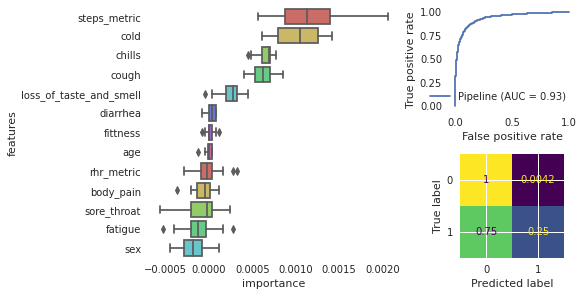

In [34]:

from sklearn.inspection import permutation_importance
from sklearn.metrics import plot_roc_curve
from matplotlib.colors import ListedColormap

color_palette = sns.color_palette("hls", 8)
colormap = ListedColormap(sns.color_palette("hls", 8).as_hex())

feature_names = [
    "rhr_metric",
    "steps_metric",
    "chills",
    "body_pain",
    "loss_of_taste_and_smell",
    "fatigue",
    "cough",
    "cold",
    "diarrhea",
    "sore_throat",
    "fittness",
    "sex",
    "age"
]
target = 'test_result'

def plot_analysis(classifier, X_test, y_test, feature_names, threshold):
    def plot_feature_importance(ax, classifier, X_test, y_test, feature_names):
        """Box plot of permutation feature importance
        """
        importance = permutation_importance(classifier, X_test, y_test, n_repeats=20)
        decreasing_importance = pd.DataFrame(
            {'mean': importance['importances_mean'], 'label': feature_names}).sort_values(
            'mean', ascending=False).label.values

        df = pd.DataFrame(columns=pd.Index(data=feature_names, name='features'),
                          data=importance['importances'].T).stack(
            'features').reset_index()
        df.columns = ['iter', 'features', 'importance']
        sns.boxplot(y='features', x='importance', data=df, order=decreasing_importance, ax=ax, palette=color_palette)

    def plot_confusion_matrix_with_threshold(ax, classifier, X_test, y_test, threshold):
        
        proba = classifier.predict_proba(X_test)
        y_pred = (proba > threshold).T[1]
        
        cm = confusion_matrix(y_test, y_pred, sample_weight=None,
                              labels=None, normalize='true')
        
        display_labels = pipeline.classes_
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=display_labels)
        
        plot = disp.plot(include_values=True,
                         ax=ax, xticks_rotation='horizontal',
                         values_format=None, colorbar=False)
        
        print(plot.text_[0][0])

    def plot_roc_vs_threshold(ax, classifier, X_test, y_test):
        plot_roc_curve(classifier,  X_test, y_test, ax=ax)
        ax.set_ylabel('True positive rate')
        ax.set_xlabel('False positive rate')

    with plt.style.context('seaborn'):
        plt.rcParams.update({
            "figure.facecolor": (1.0, 1.0, 1.0, 0.3),  # white   with alpha = 30%
            "axes.facecolor": (1.0, 1.0, 1.0, 0.5),  # white with alpha = 50%
            "savefig.facecolor": (1.0, 1.0, 1.0, 0.2),  # white  with alpha = 20%
        })
        fig, axes = plt.subplot_mosaic(
            [
                ['left', 'upper right'],
                ['left', 'lower right']
            ],
            figsize=(8,  4), 
            constrained_layout=True, 
            gridspec_kw={
                'width_ratios':[2, 1], 
                'height_ratios': [1,  1]
            }
        )

        plot_roc_vs_threshold(axes['upper right'], pipeline, X_test, y_test)
        plot_feature_importance(axes['left'], classifier, X_test, y_test, feature_names)
        plot_confusion_matrix_with_threshold(axes['lower right'], classifier, X_test, y_test, threshold)

        fig.savefig('model_metrics.png', dpi=300)

pipeline, X_test, y_test = train_model(feature_names, target, cleaned_feature_data)

plot_analysis(pipeline, X_test, y_test, feature_names, 0.5)

In [5]:
cleaned_features = feature_data.dropna(axis=0, subset=feature_names)

In [6]:
# Load reported incidences from File
online_source = 'https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Inzidenz_Impfstatus.xlsx?__blob=publicationFile'
from datetime import datetime

local_source = os.path.join(os.path.dirname(notebook_path), 'Inzidenz_Impfstatus.xlsx')


def load_excel(path):
    data = pd.read_excel(
        path,
        sheet_name=1, header=3
    )[['Mit Auffrischimpfung 18-59 Jahre', 'Grundimmunisierte  18-59 Jahre', 'Ungeimpfte 18-59 Jahre'
        , 'Meldejahr', 'Meldewoche']]
    data['date'] = data.apply(
        lambda row: datetime.strptime(str(row['Meldejahr']) + "-" + str(row['Meldewoche']) + '-1', "%Y-%W-%w"),
        axis=1)
    return data[data['Mit Auffrischimpfung 18-59 Jahre'] != '--'].drop(columns=['Meldejahr', 'Meldewoche'])


try:
    reported_incidence = load_excel(online_source)
except Exception as e:
    print('online source not available', e)
    reported_incidence = load_excel(local_source)
reported_incidence.head()

online source not available HTTP Error 403: Forbidden


,Mit Auffrischimpfung 18-59 Jahre,Grundimmunisierte 18-59 Jahre,Ungeimpfte 18-59 Jahre,date
14,28.150208,56.713818,176.191162,2021-10-18
15,43.242805,76.701698,226.838531,2021-10-25
16,42.874035,94.031586,265.999084,2021-11-01
17,56.454918,119.030441,326.103210,2021-11-08
18,59.637115,140.133987,352.588928,2021-11-15


In [35]:
MEAN_DAYS = 7


@R.curry
def predicted_incidence(classifier, feature_data):
    proba_infected = classifier.predict_proba(feature_data[feature_names].values).T[1].T

    p = pd.DataFrame(
        data=proba_infected, index=cleaned_features.index, columns=["probability"]
    )

    colname = f"{MEAN_DAYS}d rolling mean detections"

    p[colname] = p["probability"] > 0.5

    p['all'] = p['probability'] > 0

    # if individuals are detected as infected in more than one week, take only the first detection
    only_first_positive_detections = (p[p[colname] == True]
                                      .reset_index()
                                      .sort_values(['user_id', 'date'])
                                      .groupby(['user_id'])
                                      .agg({colname: 'first', 'all': 'first', 'date': lambda x: list(x)[0]})
                                      .reset_index()
                                      )
    all_negative_detections = p[p[colname] == False].reset_index()

    detected_infections = pd.concat([only_first_positive_detections, all_negative_detections])

    detected_infections['date'] = detected_infections['date'].apply(
        lambda d: d + timedelta(days=int(random.randint(0, 7, 1))))

    rolling_mean_detections = (
        detected_infections
            .groupby("date")
            .sum()
            .rolling(f'{MEAN_DAYS}D').mean()
            .drop(columns=["probability", "user_id"])
    )

    rolling_mean_detections[colname] = rolling_mean_detections[colname].div(rolling_mean_detections['all'],
                                                                            axis=0) * 100_000

    return rolling_mean_detections.reset_index(), colname


runs = []
for i in range(10):
    pipeline, X_test, y_test = train_model(feature_names, target, cleaned_feature_data, random_state=i)
    nowcasted_incidence, predicted_incidence_column = predicted_incidence(pipeline, cleaned_features)
    nowcasted_incidence['run_id'] = i
    runs.append(
        nowcasted_incidence[[predicted_incidence_column, 'run_id', 'date']])

predicted_incidence_runs = pd.concat(runs).reset_index().sort_values('date')

predicted_incidence_plot_data = predicted_incidence_runs.groupby('date').agg(
    {predicted_incidence_column: ['mean', 'std']}).reset_index()
predicted_incidence_plot_data.columns = ['date', 'mean', 'std']

In [36]:
import plotly.graph_objects as go

default_layout = dict(
    title={"y": 0.92, "x": 0.5, "xanchor": "center", "yanchor": "top"},
    font_size=12,
    autosize=True,
    height=600,
    margin=dict(l=60, r=30, b=75, t=30, pad=0),
    template="plotly_white",
    hovermode="x",
    legend={
        "font_size": 11,
        'x': 0,
        'y': 1,
        "itemclick": "toggleothers",
        "itemdoubleclick": "toggle",
        "tracegroupgap": 2,
    },
    hoverlabel={"font_color": "white", "namelength": -1},
    xaxis={
        "showline": True,
        "linewidth": 1.5,
        "linecolor": "#455266",
        "ticks": "outside",
        "tickwidth": 1.5,
        "rangemode": "nonnegative",
    },
    yaxis={
        "showline": True,
        "linewidth": 1.5,
        "linecolor": "#455266",
        "ticks": "outside",
        "tickwidth": 1.5,
        "rangemode": "nonnegative",
    },
    showlegend=True,
)

i18n = {'de': {
    'booster': 'Mit Auffrischimpfung 18-59 Jahre',
    'base': 'Grundimmunisierte  18-59 Jahre',
    'unvax': 'Ungeimpfte 18-59 Jahre',
    'title': 'Gemeldete Inzidenz vs. Machine Learning Nowcast',
    'y_axis_title': 'Inzidenz',
    'nowcast': 'Nowcast',
    'insecurity': 'Modell Unsicherheit'
}, 'en': {
    'booster': 'With booster 18-59 years',
    'base': 'Vaccinated  18-59 years',
    'unvax': 'Unvaccinated 18-59 years',
    'title': 'Reported Incidence vs. Machine Learning Nowcast',
    'y_axis_title': 'Incidence',
    'nowcast': 'Nowcast',
    'insecurity': 'Confidence interval'
}}

for language, translation in i18n.items():
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        y=predicted_incidence_plot_data['mean'].values[10:] + 2 * predicted_incidence_plot_data['std'].values[10:],
        x=predicted_incidence_plot_data['date'].values[10:],
        showlegend=False,
        legendgroup='nowcast',
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        hoverinfo='skip'
    ))
    fig.add_trace(go.Scatter(
        name=translation['insecurity'],
        y=predicted_incidence_plot_data['mean'].values[10:] - 2 * predicted_incidence_plot_data['std'].values[10:],
        x=predicted_incidence_plot_data['date'].values[10:],
        showlegend=False,
        legendgroup='nowcast',
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(65, 172, 221, 0.3)',  #'rgba(68, 68, 68, 0.3)'
        fill='tonexty',
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        y=predicted_incidence_plot_data['mean'].values[10:-1],
        x=predicted_incidence_plot_data['date'].values[10:-1],
        name=translation['nowcast'],
        legendgroup='nowcast',
        mode='lines',
        hovertemplate="%{y:.0f}",
        line=dict(width=2.5,
                  color='#41ACDD'  #455266
                  )))

    fig.add_trace(go.Scatter(
        y=reported_incidence['Mit Auffrischimpfung 18-59 Jahre'].values[1:],
        x=reported_incidence['date'].values[1:],
        name=translation['booster'],
        mode='markers',
        hovertemplate="%{y:.0f}",
        marker=dict(size=8,
                    color='white',  #41ACDD
                    line=dict(width=2., color='red')  #DarkSlateGrey
                    )))

    fig.add_trace(go.Scatter(
        y=reported_incidence['Grundimmunisierte  18-59 Jahre'].values[1:],
        x=reported_incidence['date'].values[1:],
        name=translation['base'],
        mode='markers',
        hovertemplate="%{y:.0f}",
        marker=dict(size=9,
                    color='red',  #455266
                    # line=dict(width=1.5, color='DarkSlateGrey')
                    )
    ))

    fig.add_trace(go.Scatter(
        y=reported_incidence['Ungeimpfte 18-59 Jahre'].values[1:],
        x=reported_incidence['date'].values[1:],
        name=translation['unvax'],
        mode='markers',
        hovertemplate="%{y:.0f}",
        marker=dict(size=9,
                    color='#455266',  #red
                    # line=dict(width=1.5, color='DarkSlateGrey')
                    )))

    layout = dict(
        title_text=translation['title'],
        yaxis_title=translation['y_axis_title'],
        hovermode='x unified',
        hoverlabel={'font': {
            'color': 'black',
        }},
    )
    fig.update_layout(default_layout)
    fig.update_layout(layout)
    fig.write_html(f'incidence_nowcast_{language}.html', include_plotlyjs='cdn', full_html=False,
                   config={'responsive': 'true', 'displayModeBar': False})
    
fig.write_image(f"incidence_nowcast.png")
fig.show()